In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from skimage import io

from data_generator import *
from dice_loss import *
from unet import *

Using TensorFlow backend.


In [8]:
TRAIN_PATH = 'data/train/'
XTRAIN_PATH = f'{TRAIN_PATH}/image'
YTRAIN_PATH = f'{TRAIN_PATH}/label'

TEST_PATH = 'data/test/'
XTEST_PATH = f'{TEST_PATH}/image'
YTEST_PATH = f'{TEST_PATH}/label'

# STEPS=2000
STEPS = 50
EPOCHS=2
# EPOCHS = 1
MODEL_NAME = 'unet_lidc.hdf5'

## Data Generation and Augmentation

In [29]:
train_generator = generator(
    TRAIN_PATH,
    image_generator_train,
    label_generator_train
)
test_generator = generator(
    TEST_PATH,
    image_generator_test,
    label_generator_test
)

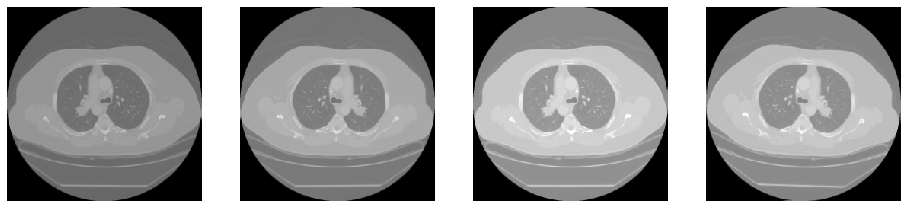

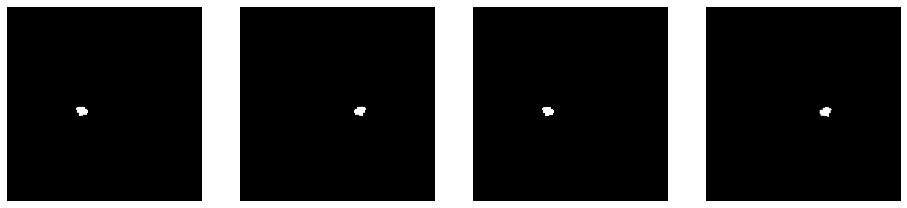

In [6]:
show_augmentation('data/train/image/0.png', image_generator_train, n_rows=1)
show_augmentation('data/train/label/0.png', label_generator_train, n_rows=1)

## Instantiate the U-Net

In [9]:
model = unet()
model.compile(
    optimizer = Adam(lr = 1e-4),
    loss=dice_coef_loss,
    metrics = [
        'accuracy',
        dice_coef,
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.
        metrics.TruePositives()
    ]
)
model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='loss',verbose=1, save_best_only=True)

## Train the U-Net

In [10]:
model.fit_generator(
    train_generator,
    steps_per_epoch=STEPS,
    epochs=EPOCHS,
    callbacks=[model_checkpoint]
)

Epoch 1/2
Found 38 images belonging to 1 classes.
Found 38 images belonging to 1 classes.
49/50 [============================>.] - ETA: 8s - loss: 0.9978 - accuracy: 0.9798 - dice_coef: 0.0022 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - true_negatives_1: 6292698.0000 - true_positives_1: 0.0000e+00 
Epoch 00001: loss improved from inf to 0.99778, saving model to unet_lidc.hdf5
50/50 [==============================] - 444s 9s/step - loss: 0.9978 - accuracy: 0.9802 - dice_coef: 0.0022 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - true_negatives_1: 6423606.0000 - true_positives_1: 0.0000e+00
Epoch 2/2
49/50 [============================>.] - ETA: 8s - loss: 0.9976 - accuracy: 0.9981 - dice_coef: 0.0024 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - true_negatives_1: 6410474.0000 - true_positives_1: 0.0000e+00 
Epoch 00002: loss improved from 0.99778 to 0.99762, saving model to unet_lidc.hdf5
50/50 [==============================] - 442s 9s/step - loss: 0.9976 - accuracy: 0.

## Test the U-Net

In [26]:
results = model.predict_generator(test_generator, 2, verbose=1)

Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
2/2 [==============================] - 4s 2s/step


# Visualize test results

In [30]:
batches = [next(test_generator) for _ in range(2)]
x = batches[0][0][0]
y = batches[0][1][0]

Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.


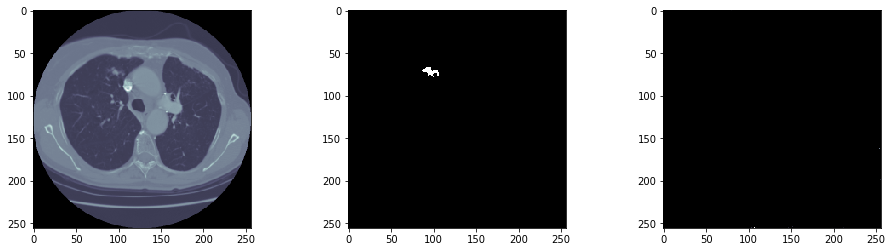

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(x.reshape(256, 256), cmap='bone')
axs[1].imshow(y.reshape(256, 256), cmap='bone')
axs[2].imshow(results[0].reshape(256, 256), cmap='bone')
plt.show()